In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
pd.set_option('display.max_rows', 8)
!date

%load_ext autoreload
%autoreload 2

Thu Sep 19 15:30:41 PDT 2019


In [2]:
plt.xkcd()

# Accuracy and privacy as a function of sample-down percentage

In [3]:
import dp_2020_census.data, dp_2020_census.model

In [4]:
df_orig = dp_2020_census.data.load_orig_counts()

In [5]:
sample_frac = 0.5
seed = 12345
df_new = dp_2020_census.data.simulate_sample_down_counts(df_orig, sample_frac, seed)

In [6]:
def my_compare(df_orig, df_new, col):
    a = df_orig.groupby(col)['count'].sum()
    a.name = 'orig'
    
    b = df_new.groupby(col)['count'].sum()
    b.name = 'new'
    
    return pd.DataFrame([a,b]).T
my_compare(df_orig, df_new, 'race')

,orig,new
race,,
1,118803172.0,118800378.0
2,12663581.0,12665450.0
3,340744.0,340968.0
4,142490.0,142838.0
5,281385.0,281684.0
6,173394.0,173448.0


In [7]:
my_compare(df_orig, df_new, 'eth')

,orig,new
eth,,
1,130202121.0,130201744.0
2,2202645.0,2203022.0


In [8]:
error = dp_2020_census.model.perturbation_error(df_orig, df_new, ['state', 'county',])

In [9]:
tc_error_50pct_sample = np.median(np.absolute(error))
tc_error_50pct_sample

90.0

In [10]:
np.percentile(np.absolute(error), 95)

372.64999999999964

In [11]:
df_epl = dp_2020_census.model.empirical_privacy_loss(error, bandwidth=.01,
                                                       est_range_percentile=95, est_range_multiplier=1.0)
df_epl

/ihme/homes/abie/projects/2019/dp_2020_census/dp_2020_census/model.py:76: RuntimeWarning: divide by zero encountered in true_divide
  ratio = f_empirical[:-1] / f_empirical[1:]
/ihme/homes/abie/projects/2019/dp_2020_census/dp_2020_census/model.py:76: RuntimeWarning: invalid value encountered in true_divide
  ratio = f_empirical[:-1] / f_empirical[1:]
/ihme/homes/abie/projects/2019/dp_2020_census/dp_2020_census/model.py:80: RuntimeWarning: divide by zero encountered in log
  df['epl_hist'] = np.log(ratio)
/ihme/homes/abie/projects/2019/dp_2020_census/dp_2020_census/model.py:83: RuntimeWarning: divide by zero encountered in log
  df['epl_cusum'] = np.log(ccusum[1:] / ccusum[:-1])


,hist,epl_hist,epl_cusum,smooth_hist,smooth_epl
-273.15,1,inf,0.000000,0.775229,-0.031781
-272.15,0,NaN,0.000000,0.800262,-0.089639
-271.15,0,-inf,-0.000715,0.875310,-0.128228
-270.15,2,0.000000,-0.000716,0.995063,-0.107940
-269.15,2,inf,0.000000,1.108481,-0.083043
...,...,...,...,...,...
267.85,4,0.693147,-0.287682,2.158048,0.015932
268.85,2,0.000000,-0.405465,2.123939,0.074301
269.85,2,0.000000,-0.693147,1.971848,0.127436
270.85,2,0.693147,-0.693147,1.735916,0.151454


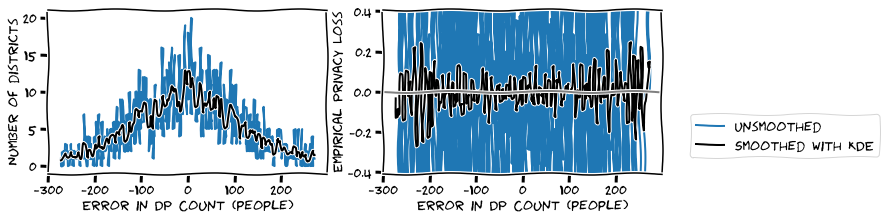

In [13]:
def my_plot(df_epl):
    fig, ax = plt.subplots(ncols=2, figsize=(11, 3))
    ax[0].plot(df_epl['hist'], linewidth=2)
    ax[0].plot(df_epl['smooth_hist'], color='k')
    ax[0].set_ylabel('Number of districts')
    ax[0].set_xlabel('Error in DP Count (people)')

    ax[1].plot(df_epl['epl_hist'], linewidth=2, color='C0', label='Unsmoothed')
    ax[1].plot(df_epl['smooth_epl'], color='k', label='Smoothed with KDE')
    ax[1].axhline(0, color='k', alpha=.5)

    ax[1].legend(loc=(1.1, .1))
    ax[1].set_ylabel('Empirical Privacy Loss')
    ax[1].set_xlabel('Error in DP Count (people)')
    bnd = max(np.absolute(df_epl.smooth_epl))*1.5
    ax[1].set_ylim(ymin=-bnd, ymax=bnd)

my_plot(df_epl)

In [14]:
def sample_down_error(df_orig, sample_frac, stratification_cols):
    error = []

    for run in '1234':
        seed = 12345 + int(run)
        df_new = dp_2020_census.data.simulate_sample_down_counts(df_orig, sample_frac, seed)

        error_run = dp_2020_census.model.perturbation_error(df_orig, df_new, stratification_cols)
        error += list(error_run)
    return pd.Series(error)

In [15]:
sample_down_frac_str = '0.05 0.10 0.15 0.20 0.25 0.30 0.35 0.40 0.45 0.50 0.55 0.60 0.65 0.70 0.75 0.80 0.85 0.90 0.95'

In [16]:
def find_sample_down_error(stratification_cols=['state', 'county', 'enum_dist'], result_name='tc_enum_dist'):
    results = {}

    df_orig = dp_2020_census.data.load_orig_counts()

    for frac in sample_down_frac_str.split():
        pct_str = f'{float(frac)*100:.0f}pct'
        key = f'{result_name}_{pct_str}'
        print(key, end=' - ')
    
        error = sample_down_error(df_orig, float(frac), stratification_cols)

        mae = np.median(np.absolute(error))
        pct95 = np.quantile(np.absolute(error), 0.95)
        max_ae = max(np.absolute(error))
        rmse = np.sqrt(np.mean(np.array(error)**2))
        
        results[f'{key}_mae'] = f'{mae:.0f}'
        results[f'{key}_pct95'] = f'{pct95:.0f}'
        results[f'{key}_max_ae'] = f'{max_ae:.0f}'
        results[f'{key}_rmse'] = f'{rmse:.0f}'
        
        print(np.round(np.mean(error),2), np.round(mae,2),
              np.round(rmse, 2), np.round(pct95,1),
              max_ae)

    return results

In [17]:
%%time
find_sample_down_error(['state', 'county'], 'tc_county')

tc_county_5pct - -0.0 388.0 915.5 1642.0 12372.0
tc_county_10pct - 0.0 272.0 614.45 1097.0 6707.0
tc_county_15pct - 0.0 207.0 472.69 856.0 4317.333333332092
tc_county_20pct - -0.0 181.0 389.72 749.0 3665.0
tc_county_25pct - 0.0 155.0 348.99 621.0 3799.0
tc_county_30pct - 0.0 134.67 322.74 562.3 3653.9999999897555
tc_county_35pct - -0.0 120.14 276.0 516.7 2925.7142857281724
tc_county_40pct - -0.0 108.0 248.6 458.5 3552.0
tc_county_45pct - 0.0 97.44 222.66 410.4 3169.333333408693
tc_county_50pct - 0.0 90.0 192.41 373.0 2352.0
tc_county_55pct - -0.0 80.18 172.55 333.8 2123.2727272966877
tc_county_60pct - 0.0 62.19 142.44 262.5 1607.0769230502192
tc_county_70pct - -0.0 58.0 129.31 239.4 1495.4285714570433
tc_county_75pct - -0.0 50.33 110.66 204.3 1408.0000000065193
tc_county_80pct - 0.0 45.25 99.73 184.0 999.25
tc_county_85pct - -0.0 37.47 85.62 155.9 902.823529384099
tc_county_90pct - -0.0 29.56 69.47 120.7 829.7777778720483
tc_county_95pct - 0.0 20.42 46.97 83.0 465.1578947317321
CPU tim

{'tc_county_5pct_mae': '388',
 'tc_county_5pct_pct95': '1642',
 'tc_county_5pct_max_ae': '12372',
 'tc_county_5pct_rmse': '915',
 'tc_county_10pct_mae': '272',
 'tc_county_10pct_pct95': '1097',
 'tc_county_10pct_max_ae': '6707',
 'tc_county_10pct_rmse': '614',
 'tc_county_15pct_mae': '207',
 'tc_county_15pct_pct95': '856',
 'tc_county_15pct_max_ae': '4317',
 'tc_county_15pct_rmse': '473',
 'tc_county_20pct_mae': '181',
 'tc_county_20pct_pct95': '749',
 'tc_county_20pct_max_ae': '3665',
 'tc_county_20pct_rmse': '390',
 'tc_county_25pct_mae': '155',
 'tc_county_25pct_pct95': '621',
 'tc_county_25pct_max_ae': '3799',
 'tc_county_25pct_rmse': '349',
 'tc_county_30pct_mae': '135',
 'tc_county_30pct_pct95': '562',
 'tc_county_30pct_max_ae': '3654',
 'tc_county_30pct_rmse': '323',
 'tc_county_35pct_mae': '120',
 'tc_county_35pct_pct95': '517',
 'tc_county_35pct_max_ae': '2926',
 'tc_county_35pct_rmse': '276',
 'tc_county_40pct_mae': '108',
 'tc_county_40pct_pct95': '458',
 'tc_county_40pct_ma

In [ ]:
%%time

results = {}

results.update(find_sample_down_error(['state'], 'tc_state'))
results.update(find_sample_down_error(['state', 'county'], 'tc_county'))
results.update(find_sample_down_error(['state', 'county', 'enum_dist'], 'tc_enum_dist'))

results.update(find_sample_down_error(['state', 'age', 'race', 'eth'], 'sc_state'))
results.update(find_sample_down_error(['state', 'county', 'age', 'race', 'eth'], 'sc_county'))
results.update(find_sample_down_error(['state', 'county', 'enum_dist', 'age', 'race', 'eth'], 'sc_enum_dist'))

len(results)

tc_state_5pct - -0.12 3883.0 7860.44 16602.0 34244.0
tc_state_10pct - 0.08 2586.0 4868.67 9359.0 20824.0
tc_state_15pct - 0.01 1383.33 3827.68 6573.3 16968.666666440666
tc_state_20pct - -0.02 1201.0 3531.01 10339.0 11534.0
tc_state_25pct - 0.04 1283.0 2564.65 5282.0 10315.0
tc_state_30pct - 0.01 1102.67 2281.18 4968.7 8918.999999692664
tc_state_35pct - -0.01 763.71 2089.64 3442.0 10293.285714939237
tc_state_40pct - -0.02 660.0 1595.43 3496.5 4803.5
tc_state_45pct - 0.01 643.44 1611.17 4267.7 4910.444446224719
tc_state_50pct - 0.0 932.0 1686.53 4608.0 5081.0
tc_state_55pct - -0.01 645.45 1125.94 2322.4 4244.454546098597
tc_state_60pct - 0.01 475.67 1121.52 2377.3 4252.333333572373
tc_state_65pct - 0.0 422.08 948.93 2256.2 4095.9230761909857
tc_state_70pct - -0.01 413.29 961.31 1711.1 3938.000000707805
tc_state_75pct - -0.01 390.33 786.32 1847.0 2170.0000000800937
tc_state_80pct - -0.0 273.29 584.07 1196.2 1834.2941177254543
tc_state_90pct - -0.01 285.11 508.54 1061.9 1446.7777767637745


In [ ]:
import json
with open('/ihme/homes/abie/projects/2019/dp_2020_census/results_sd_error.json', 'w') as f:
    json.dump(results, f, indent=4)

In [ ]:
results['tc_enum_dist_50pct_mae']

# Now calculate the empirical privacy loss

In [ ]:
def find_sample_down_epl(stratification_cols=['state', 'county', 'enum_dist'],
                         result_name='tc_privacy_loss_enum_dist'):
    results = {}

    df_orig = dp_2020_census.data.load_orig_counts()


    for frac in sample_down_frac_str.split():
        pct_str = f'{float(frac)*100:.0f}pct'
        key = f'{result_name}_{pct_str}'
        print(key, end=' - ')
    
        error = sample_down_error(df_orig, float(frac), stratification_cols)
        
        df_epl = dp_2020_census.model.empirical_privacy_loss(error, bandwidth=.01,
                                                       est_range_percentile=95, est_range_multiplier=1.0)
        max_abs = max(np.absolute(df_epl.smooth_epl))

        results[f'{key}_max_abs'] = f'{max_abs:.3f}'
        
        print(results[f'{key}_max_abs'])

    return results
# find_sample_down_epl(['state',], 'tc_privacy_loss_state')

In [ ]:
%%time

results = {}

results.update(find_sample_down_epl(['state'], 'tc_state'))
results.update(find_sample_down_epl(['state', 'county'], 'tc_privacy_loss_county'))
results.update(find_sample_down_epl(['state', 'county', 'enum_dist'], 'tc_privacy_loss_enum_dist'))

results.update(find_sample_down_epl(['state', 'age', 'race', 'eth'], 'sc_privacy_loss_state'))
results.update(find_sample_down_epl(['state', 'county', 'age', 'race', 'eth'], 'sc_privacy_loss_county'))
results.update(find_sample_down_epl(['state', 'county', 'enum_dist', 'age', 'race', 'eth'],
                           'sc_privacy_loss_enum_dist'))

with open('/ihme/homes/abie/projects/2019/dp_2020_census/results_sd_epl.json', 'w') as f:
    json.dump(results, f, indent=4)

In [ ]:
frac = '0.05'
stratification_cols = ['state', 'county', 'enum_dist', 'age', 'race', 'eth']

error = sample_down_error(df_orig, float(frac), stratification_cols)
df_epl = dp_2020_census.model.empirical_privacy_loss(error, bandwidth=.01,
                                                       est_range_percentile=95, est_range_multiplier=2.0)

my_plot(df_epl)